# Read data and pre-process data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm
import cv2
from skimage.feature import hog
from sklearn.metrics import classification_report, accuracy_score

In [2]:
artists_path = '/kaggle/input/best-artworks-of-all-time/artists.csv'
artists_df = pd.read_csv(artists_path)

# Get the top 11 artists with more than 200 paintings
top_artists = artists_df[['name', 'paintings']].sort_values(by='paintings', ascending=False).head(11)
print("Top 11 Artists:")
print(top_artists)

updated_name = "Albrecht_Dürer".replace("_", " ")
top_artists.iloc[4, 0] = updated_name

# Extract names of top artists
top_artist_names = top_artists['name'].tolist()
print(top_artist_names)

Top 11 Artists:
                     name  paintings
8        Vincent van Gogh        877
30            Edgar Degas        702
13          Pablo Picasso        439
15  Pierre-Auguste Renoir        336
19         Albrecht Dürer        328
46           Paul Gauguin        311
16         Francisco Goya        291
31              Rembrandt        262
20          Alfred Sisley        259
32                 Titian        255
22           Marc Chagall        239
['Vincent van Gogh', 'Edgar Degas', 'Pablo Picasso', 'Pierre-Auguste Renoir', 'Albrecht Dürer', 'Paul Gauguin', 'Francisco Goya', 'Rembrandt', 'Alfred Sisley', 'Titian', 'Marc Chagall']


In [3]:
images_dir = '/kaggle/input/best-artworks-of-all-time/images/images'
artists_dirs = os.listdir(images_dir)
top_artist_names = top_artists['name'].str.replace(' ', '_').values

# See if all directories exist
for name in top_artist_names:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

Found --> /kaggle/input/best-artworks-of-all-time/images/images/Vincent_van_Gogh
Found --> /kaggle/input/best-artworks-of-all-time/images/images/Edgar_Degas
Found --> /kaggle/input/best-artworks-of-all-time/images/images/Pablo_Picasso
Found --> /kaggle/input/best-artworks-of-all-time/images/images/Pierre-Auguste_Renoir
Found --> /kaggle/input/best-artworks-of-all-time/images/images/Albrecht_Dürer
Found --> /kaggle/input/best-artworks-of-all-time/images/images/Paul_Gauguin
Found --> /kaggle/input/best-artworks-of-all-time/images/images/Francisco_Goya
Found --> /kaggle/input/best-artworks-of-all-time/images/images/Rembrandt
Found --> /kaggle/input/best-artworks-of-all-time/images/images/Alfred_Sisley
Found --> /kaggle/input/best-artworks-of-all-time/images/images/Titian
Found --> /kaggle/input/best-artworks-of-all-time/images/images/Marc_Chagall


# Extract features (HOG)

In [4]:
image_size = (224, 224)

# Extract features
def extract_features(image_path, feature_type="hog"):
    # Read and resize the image
    img = cv2.imread(image_path)
    img = cv2.resize(img, image_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    
    if feature_type == "hog":
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hog_features = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9, block_norm='L2-Hys')
        return hog_features
    
    else:
        raise ValueError("Unknown feature_type!")

data = []
labels = []
artist_to_label = {artist: i for i, artist in enumerate(top_artist_names)}

# Load and process each image
for artist in top_artist_names:
    artist_dir = os.path.join(images_dir, artist)
    if os.path.exists(artist_dir):
        for image_name in os.listdir(artist_dir):
            image_path = os.path.join(artist_dir, image_name)
            try:
                # Extract features
                features = extract_features(image_path, feature_type="hog")
                data.append(features)
                labels.append(artist_to_label[artist])
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")

data = np.array(data)
labels = np.array(labels)

# Normalize pixel values
data = data / 255.0

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(f"Feature matrix shape: {data.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


Feature matrix shape: (4299, 26244)
Labels shape: (4299,)
Training samples: 3439
Testing samples: 860


# Perform GridSearchCV to determine the best parameters combination

In [6]:
# Train an SVM with GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.1, 1],
    'kernel': ['rbf']
}

svm = SVC()
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, verbose=3, n_jobs=1)
grid_search.fit(X_train, y_train)

# Best parameters and best model
print("Best parameters found by GridSearchCV:", grid_search.best_params_)
best_svm = grid_search.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.201 total time= 3.9min
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.201 total time= 3.8min
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.201 total time= 3.7min
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.201 total time= 3.7min
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.199 total time= 3.7min
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.201 total time= 3.2min
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.201 total time= 3.2min
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.201 total time= 3.2min
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.201 total time= 3.3min
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.199 total time= 3.2min
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.201 total time= 3.3min
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;,

## Plot result of GridSearchCV

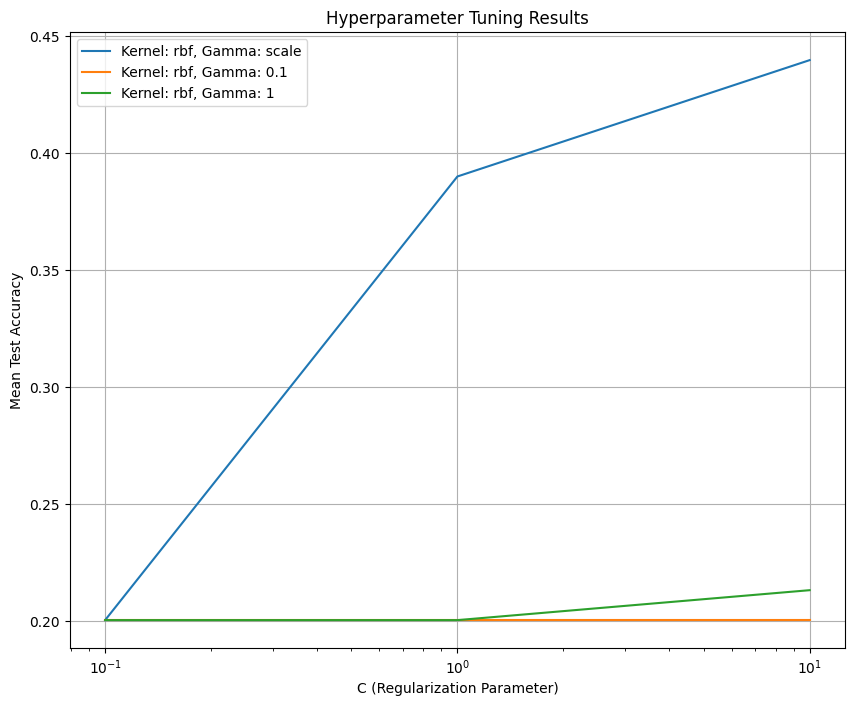

In [7]:
# Extract results from the grid search
results = pd.DataFrame(grid_search.cv_results_)

# Plot mean test scores for each combination of parameters
plt.figure(figsize=(10, 8))

# Iterate through unique kernel types
for kernel in results['param_kernel'].unique():
    kernel_results = results[results['param_kernel'] == kernel]
    
    for gamma in kernel_results['param_gamma'].unique():
        gamma_results = kernel_results[kernel_results['param_gamma'] == gamma]
        plt.plot(
            gamma_results['param_C'], 
            gamma_results['mean_test_score'], 
            label=f"Kernel: {kernel}, Gamma: {gamma}"
        )

plt.xscale('log')
plt.xlabel("C (Regularization Parameter)")
plt.ylabel("Mean Test Accuracy")
plt.title("Hyperparameter Tuning Results")
plt.legend()
plt.grid()
plt.show()

# Evaluate model on test dataset

Training Accuracy: 100.00%
Test Accuracy: 47.09%
Classification Report:
                       precision    recall  f1-score   support

     Vincent van Gogh       0.39      0.73      0.51       188
          Edgar Degas       0.53      0.73      0.61       153
        Pablo Picasso       0.42      0.51      0.46        83
Pierre-Auguste Renoir       0.47      0.21      0.29        67
      Albrecht Dürer       0.50      0.22      0.30        74
         Paul Gauguin       0.14      0.02      0.03        51
       Francisco Goya       0.61      0.37      0.46        51
            Rembrandt       0.68      0.38      0.49        50
        Alfred Sisley       0.62      0.39      0.48        51
               Titian       0.69      0.22      0.33        51
         Marc Chagall       0.67      0.34      0.45        41

             accuracy                           0.47       860
            macro avg       0.52      0.37      0.40       860
         weighted avg       0.49      0.47  

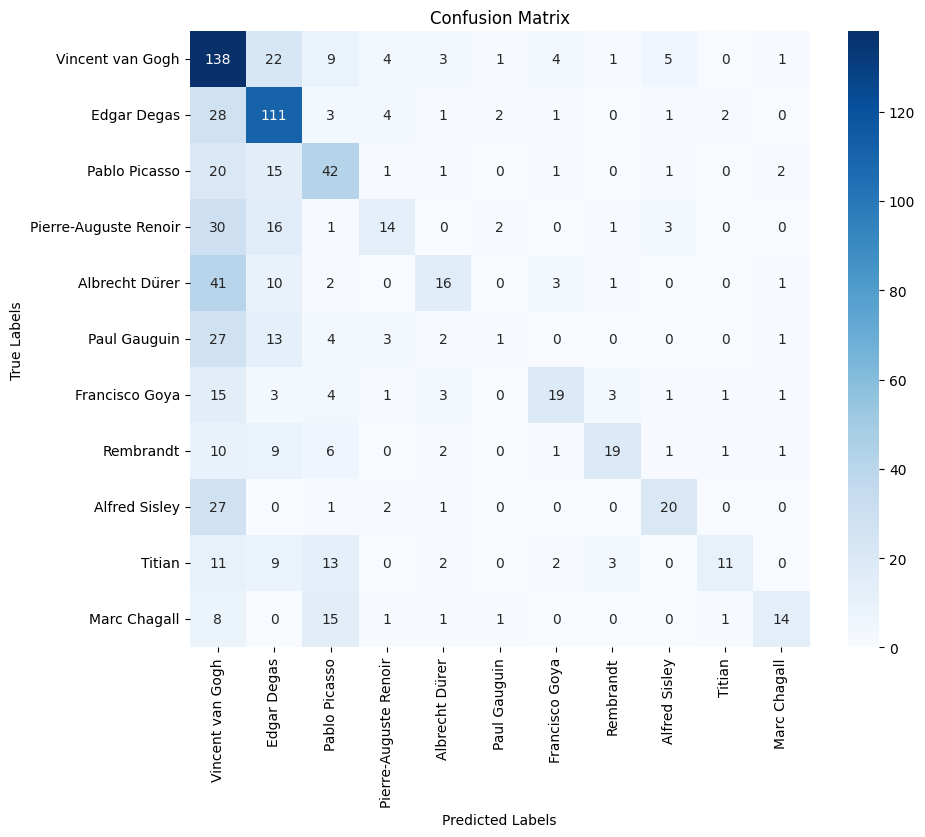

In [5]:
best_svm = SVC(C=10, gamma='scale', kernel='rbf')
best_svm.fit(X_train, y_train)

# Training and Testing Accuracy
y_train_pred = best_svm.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

y_pred = best_svm.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Detailed performance
class_names = [name.replace('_', ' ') for name in top_artist_names]
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()